This code is the work of Farokh Cooper (CWID: 20016578)

Creating a Content Based Auto Encoder filter.
---



In [8]:
## Importing the necessary libraries
## We use sci-kit learn, tensor-flow, pandas, seaborn and numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os as os
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Dropout, concatenate, multiply, Input, Reshape, dot, BatchNormalization, Activation
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adamax, Adagrad
from keras.losses import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf


In [9]:
## Importing the csv files
## Using 20 million Movielens dataset

movie_data = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags_data = pd.read_csv('tags.csv')

In [10]:
## Returning user and movie counts

user_ratings_count = ratings.groupby(['UserID']).count()['MovieID']
movie_ratings_count = ratings.groupby(['MovieID']).count()['UserID']
print("Number of unique users in ratings data:", len(user_ratings_count))
print("Number of unique movies in ratings data:", len(movie_ratings_count))

Number of unique users in ratings data: 35699
Number of unique movies in ratings data: 20573


Checking for any null values

In [11]:
ratings['UserID'].isnull().any()

False

In [12]:
ratings['MovieID'].isnull().any()

True

In [13]:
ratings['rating'].isnull().any()


True

In [14]:
movie_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [15]:
## Returning the number of unique users and movies

print(ratings.head())

unique_users = len(ratings['UserID'].unique())
unique_movies = len(ratings['MovieID'].unique())
print("Number of unique users in ratings file:",unique_users)
print("Number of unique movies in ratings file:",unique_movies)

   userId  movieId  rating     timestamp
0       1      2.0     3.5  1.112486e+09
1       1     29.0     3.5  1.112485e+09
2       1     32.0     3.5  1.112485e+09
3       1     47.0     3.5  1.112485e+09
4       1     50.0     3.5  1.112485e+09
Number of unique users in ratings file: 35699
Number of unique movies in ratings file: 20574


In [16]:
tags_data.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [17]:
## Creating a dataframe for the tags data
## Grouping the tags based on MovieID
## Resetting the MovieID to tag.MovieID

tags_data.fillna("", inplace=True)
tags_data = pd.DataFrame(tags_data.groupby('MovieID')['tag'].apply(lambda x: "{%s}" % ' '.join(x)))
tags_data.reset_index(inplace=True)
movie_id = tags_data.MovieID
print("The number of unique movies is:",len(movie_id))
tags_data.sample(7)

The number of unique movies is: 19545


,movieId,tag
12658,77364,{action comedy Jeffrey Dean Morgan action audi...
4280,5050,{writers}
12153,72261,{Don Bluth Nostalgia Critic}
13929,87042,{BD-R}
18845,119080,{Manish Acharya}
5801,6832,{Annette Bening Julie Follansbhee Michael Hale...
13949,87194,{conversion Good acting Martin Sheen missionar...


In [18]:
## Merging the tags movi_data and tag_data to create a tag document

tags = pd.merge(movie_data, tags_data, left_index=True, right_on='MovieID', how='right')
tags['document'] = tags[['tag', 'genres']].apply(lambda x: ''.join(str(x)), axis=1)
tags.head(4)

,movieId,movieId_x,title,genres,movieId_y,tag,document
0,1,2.0,Jumanji (1995),Adventure|Children|Fantasy,1,{Watched computer animation Disney animated fe...,tag {Watched computer animation Disney a...
1,2,3.0,Grumpier Old Men (1995),Comedy|Romance,2,{time travel adapted from:book board game chil...,tag {time travel adapted from:book board...
2,3,4.0,Waiting to Exhale (1995),Comedy|Drama|Romance,3,{old people that is actually funny sequel feve...,tag {old people that is actually funny s...
3,4,5.0,Father of the Bride Part II (1995),Comedy,4,{chick flick revenge characters chick flick ch...,tag {chick flick revenge characters chic...


In [19]:
tags.query('MovieID == 70').tag.values

array(["{twist ending Sexualized violence splatter violence very unrealistic bloody vampires brothers campy cult film George Clooney gore horror hostage intense mexico plot twist Quentin Tarantino Robert Rodriguez Sexualized violence strippers Tarantino twist ending vampire vampires violence cult film mexico Quentin Tarantino Sexualized violence vampires violence cult classic cult film so bad it's good Tarantino Danny Trejo twist ending vampire vampires violence action funny Tarantino vampires cult classic cult classic to see: b-grade horror strippers vampires cult film Quentin Tarantino twist ending campy genre mix gore mixed genre Quentin Tarantino twist ending vampire vampires foot fetish cult classic cult film Tarantino cult film Quentin Tarantino George Clooney Harvey Keitel twist ending Tarantino bar brawl brothers George Clooney horror mexico Quentin Tarantino Salma Hayek Sexualized violence twist ending cult film Quentin Tarantino twist ending cult classic cult classic Tarantin

In [20]:
## Creating a TF-IDF vectorizer
## Setting n-gram range to create continous data between 0 to 1
## TF-IDF matrix is generated and added to a dataframe

tfidf = TfidfVectorizer(
    ngram_range=(0, 1),
    min_df=0.0001,
    stop_words='english')
tfidf_matrix = tfidf.fit_transform(tags['tag'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=tags.index.tolist())

In [21]:
# tfidf.vocabulary

tfidf_mat = tfidf_matrix.toarray()
print(type(tfidf_mat),tfidf_mat.shape)


<class 'numpy.ndarray'> (19545, 13048)


The autoencoder function:

In [22]:
input_size = tfidf_mat.shape[1]
intermediate_size=800
encoded_size=90

def autoencoder():
    
    #encoder function

    model = Sequential()              ## Creating a Sequential model
    model.add(Dense(intermediate_size,input_shape=(input_size,)))     ## Adding a Dense Layer
    model.add(Dropout(0.2))               ## regularization of the model
    model.add(Activation('relu'))     ## Activation function is Relu 
    model.add(BatchNormalization(axis=1, name='bn_encoder1'))  ## Adding Batch Normalization
    
    model.add(Dense(encoded_size))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=1, name='bn_encoder2'))
    
    #decoder function

    model.add(Dense(encoded_size))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=1, name='bn_decoder1'))
    
    model.add(Dense(intermediate_size))
    model.add(BatchNormalization(axis=1, name='bn_decoder2'))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    
    model.add(Dense(input_size,))     ## The layer has the Sigmoid activation function
    model.add(Activation('sigmoid'))
    return model

In [23]:
ae = autoencoder()      ## Creating the autoencoder object

In [24]:
ae.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 800)               10439200  
                                                                 
 dropout (Dropout)           (None, 800)               0         
                                                                 
 activation (Activation)     (None, 800)               0         
                                                                 
 bn_encoder1 (BatchNormaliza  (None, 800)              3200      
 tion)                                                           
                                                                 
 dense_1 (Dense)             (None, 90)                72090     
                                                                 
 dropout_1 (Dropout)         (None, 90)                0         
                                                        

In [25]:
train, test = train_test_split(tfidf_mat, test_size = 0.2)      ## Train-test split is 80-20


Configuring the model for the Auto Encoder

In [26]:
## Adam optimization algorithm selected, evaluation metrics are MSE and RMSE
## Outputs the loss at each epoch

ae.compile(optimizer='Adam', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.RootMeanSquaredError()])
history = ae.fit(train, train,
                epochs=10,
                batch_size=500,
                shuffle=True,
                validation_data=(test, test)).history

Epoch 1/10
32/32 [==============================] - 42s 1s/step - loss: 0.0332 - mean_squared_error: 0.0332 - root_mean_squared_error: 0.1822 - val_loss: 0.1016 - val_mean_squared_error: 0.1016 - val_root_mean_squared_error: 0.3188
Epoch 2/10
32/32 [==============================] - 40s 1s/step - loss: 3.3512e-04 - mean_squared_error: 3.3512e-04 - root_mean_squared_error: 0.0183 - val_loss: 0.0336 - val_mean_squared_error: 0.0336 - val_root_mean_squared_error: 0.1833
Epoch 3/10
32/32 [==============================] - 39s 1s/step - loss: 2.4837e-04 - mean_squared_error: 2.4837e-04 - root_mean_squared_error: 0.0158 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_root_mean_squared_error: 0.1216
Epoch 4/10
32/32 [==============================] - 38s 1s/step - loss: 2.1730e-04 - mean_squared_error: 2.1730e-04 - root_mean_squared_error: 0.0147 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_root_mean_squared_error: 0.0836
Epoch 5/10
32/32 [==============================

Storing the losses in the loss history list and saving loss values to a csv file.

In [27]:
losses = pd.DataFrame(data=list(zip(history["loss"], history["val_loss"])), columns=['train_loss', 'validation_loss'])
losses = losses[1:]
losses['epoch'] = (losses.index + 1)
losses.to_csv("losses_autoencoder.csv")
pd.read_csv('losses_autoencoder.csv')

,Unnamed: 0,train_loss,validation_loss,epoch
0,1,0.000335,0.033614,2
1,2,0.000248,0.014776,3
2,3,0.000217,0.006995,4
3,4,0.000195,0.003723,5
4,5,0.000177,0.002094,6
5,6,0.000162,0.001299,7
6,7,0.000150,0.000843,8
7,8,0.000139,0.000605,9
8,9,0.000132,0.000449,10


Plotting the training and validation losses(MSE) against epochs:

We find that the validation loss decreases significantly with the number of epochs.

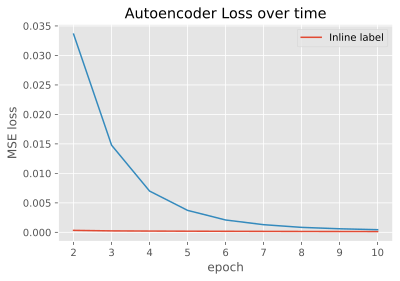

In [28]:
%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'], label='Inline label')
ax.plot(losses['epoch'], losses['validation_loss'])
ax.set_ylabel('MSE loss')
ax.set_xlabel('epoch')
ax.set_title('Autoencoder Loss over time')
ax.legend()

In [29]:
print(movie_data.iloc[0]) # MovieID of Toy Story
print(movie_data.iloc[9]) # MovieID of Golden Eye

movieId                                              1
title                                 Toy Story (1995)
genres     Adventure|Animation|Children|Comedy|Fantasy
Name: 0, dtype: object
movieId                           10
title               GoldenEye (1995)
genres     Action|Adventure|Thriller
Name: 9, dtype: object


Function for returning similar movies based on the embeddings obtained while training. Top 20 recommendations are returned.

In [30]:
def get_similar_movies(movie_id, embeddings):
    ## Get similar movies

    similarity_matrix = pd.DataFrame(cosine_similarity(       ## Creating a similarity matrix using the cosine similarity function
            X=embeddings,Y=embeddings))
    similar_items = pd.DataFrame(similarity_matrix.loc[movie_id])
    similar_items.columns = ["similarity_score"]    
    similar_items = similar_items.sort_values('similarity_score', ascending=False)    ## Sorting the top similarity score values
    similar_items.reset_index(inplace=True)
    similar_items = similar_items.rename(index=str, columns={"index": "item_id"})
    similar_movies = pd.DataFrame(similar_items.to_dict())
    similar_movies.set_index('item_id', inplace=True)
    similar_df = pd.merge(movie_data, similar_movies, left_index=True, right_index=True)
    similar_df.sort_values('similarity_score', ascending=False, inplace=True)
    similar_df.head(20).to_csv(index=False, header=True)
    return similar_df.head(20)

In [31]:
toy_story = 1  ## MovieID of Toy Story
golden_eye = 10   ## MovieID of Golden Eye

embedding = Model(ae.inputs, ae.layers[10].output)    ## creating the embeddings based on movie choices on 10 layers of the Autoencoder
ae_embedding = embedding.predict(tfidf_mat)           ## prediction for the tfidf matrix using embeddings
get_similar_movies(toy_story, ae_embedding)           ## finding similar films to Toy Story

611/611 [==============================] - 16s 26ms/step


,movieId,title,genres,similarity_score
1,2,Jumanji (1995),Adventure|Children|Fantasy,1.000000
2920,3006,"Insider, The (1999)",Drama|Thriller,0.978963
435,439,Dangerous Game (1993),Drama,0.974891
19342,96096,Mais qui a tué Pamela Rose? (2003),Comedy,0.972632
9768,31785,Frozen Land (Paha maa) (2005),Drama,0.971390
7156,7268,Love at Large (1990),Romance|Thriller,0.971094
16049,81229,Red (2010),Action|Comedy,0.970297
13092,62970,Tin Man (2007),Adventure|Fantasy|Sci-Fi,0.970038
1243,1271,Fried Green Tomatoes (1991),Comedy|Crime|Drama,0.969670
7752,8334,"Cowboys, The (1972)",Western,0.969629


Returning similar films to Golden Eye

In [32]:
get_similar_movies(golden_eye, ae_embedding)

,movieId,title,genres,similarity_score
10,11,"American President, The (1995)",Comedy|Drama|Romance,1.000000
3007,3094,Maurice (1987),Drama|Romance,0.978101
15981,80967,Harmony and Me (2009),Comedy,0.977505
14004,70227,Dark Ride (2006),Horror|Thriller,0.977206
10784,43248,Swamp Women (1956),Adventure|Crime|Horror,0.976356
13686,68411,Black Magic (Meeting at Midnight) (Charlie Cha...,Comedy|Crime|Drama,0.976270
19293,95898,"Craigslist Killer, The (2011)",Crime|Drama|Thriller,0.975546
9891,32354,Free Radicals (Böse Zellen) (2003),Drama,0.975526
14757,73820,Hannah Takes the Stairs (2007),Drama,0.975514
9140,26968,Cremaster 5 (1997),Drama|Musical,0.974966
